In [43]:
# %matplotlib qt
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import geopandas as gpd
import gsw

from shapely.geometry import LineString, Polygon, Point
from shapely.ops import polygonize, unary_union
from shapely.validation import explain_validity

from scipy.interpolate import griddata
from salishsea_tools import unit_conversions
from salishsea_tools import psu_tools
from cartopy import crs, feature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER


IOPATH = '/ocean/ghoeven/MOAD/Data/PNWCurrent_obs.csv'

In [44]:
obs = pd.read_csv(IOPATH)
obs

,Unnamed: 0.1,Unnamed: 0,time,longitude (degrees_east),latitude (degrees_north),depth (m),pressure (dbar),temperature (degC),salinity (g kg-1),DO (umol kg-1),...,Zn (nmol kg-1),source,Nstar (umol kg-1),spice,current,geometry,location,month,salinity (psu),density (kg m-3)
0,0,1271,1933-07-25 00:00:00+00:00,-126.76,49.34,1.0,1.008587,NaN,32.070847,NaN,...,NaN,ios bottle,NaN,NaN,Shelf_Current,POINT (-126.76 49.34),shelf,7,31.920329,NaN
1,1,1272,1933-07-25 00:00:00+00:00,-126.76,49.34,2.0,2.017180,NaN,32.090943,NaN,...,NaN,ios bottle,NaN,NaN,Shelf_Current,POINT (-126.76 49.34),shelf,7,31.940330,NaN
2,2,1273,1933-07-25 00:00:00+00:00,-126.76,49.34,4.0,4.034378,NaN,32.090906,NaN,...,NaN,ios bottle,NaN,NaN,Shelf_Current,POINT (-126.76 49.34),shelf,7,31.940294,NaN
3,3,1274,1933-07-25 00:00:00+00:00,-126.76,49.34,6.0,6.051598,NaN,32.090870,NaN,...,NaN,ios bottle,NaN,NaN,Shelf_Current,POINT (-126.76 49.34),shelf,7,31.940258,NaN
4,4,1275,1933-07-25 00:00:00+00:00,-126.76,49.34,10.0,10.086095,NaN,32.181305,NaN,...,NaN,ios bottle,NaN,NaN,Shelf_Current,POINT (-126.76 49.34),shelf,7,32.030268,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
937227,937227,2657130,2024-11-18 00:00:00+00:00,-124.95,44.38,0.0,0.000000,12.713836,32.386146,312.025459,...,NaN,ooi,NaN,-0.251376,NaN,POINT (-124.95 44.38),slope,11,32.234148,24.307180
937228,937228,2657131,2024-11-18 00:00:00+00:00,-124.94,44.36,0.0,0.000000,12.712860,32.386131,NaN,...,NaN,ooi,NaN,-0.251582,NaN,POINT (-124.94 44.36),slope,11,32.234133,24.307357
937229,937229,2657133,2024-11-18 00:00:00+00:00,-124.57,46.99,0.0,0.000000,10.586080,32.728763,202.661375,...,NaN,ooi,NaN,-0.405998,Shelf_Current,POINT (-124.57 46.99),shelf,11,32.575157,24.960321
937230,937230,2657134,2024-11-18 00:00:00+00:00,-124.56,46.99,0.0,0.000000,12.215222,32.245641,308.384776,...,NaN,ooi,NaN,-0.452611,Shelf_Current,POINT (-124.56 46.99),shelf,11,32.094303,24.293613


/tmp/ipykernel_655817/3249404643.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs_shelf_dd['time'] = pd.to_datetime(obs_shelf_dd['time'])


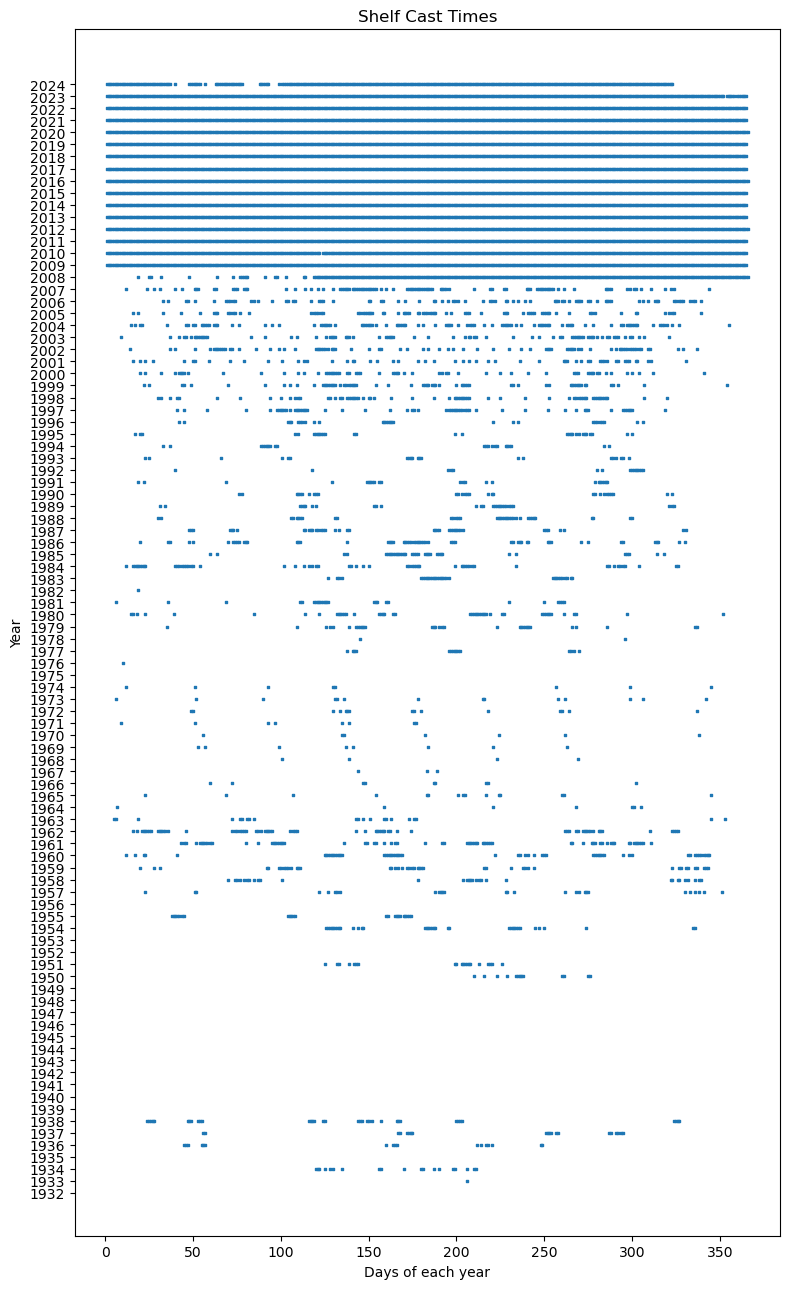

In [45]:
# Temporal resolution of Shelf Current
obs_shelf = obs[obs['current'] == 'Shelf_Current']

fig, ax = plt.subplots(figsize=(8, 13))

obs_shelf_dd = obs_shelf.drop_duplicates(subset='time', keep='first')

obs_shelf_dd['time'] = pd.to_datetime(obs_shelf_dd['time'])

yearDay = obs_shelf_dd['time'].dt.dayofyear
year = obs_shelf_dd['time'].dt.year

ax.scatter(yearDay, year, s=2, marker='s' )

ax.set_title('Shelf Cast Times')
ax.set_yticks(range(1932, 2025))  
ax.set_ylabel('Year')
ax.set_xlabel('Days of each year')

plt.tight_layout()
plt.show()

/tmp/ipykernel_655817/2185508098.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs_cuc_dd['time'] = pd.to_datetime(obs_cuc_dd['time'])


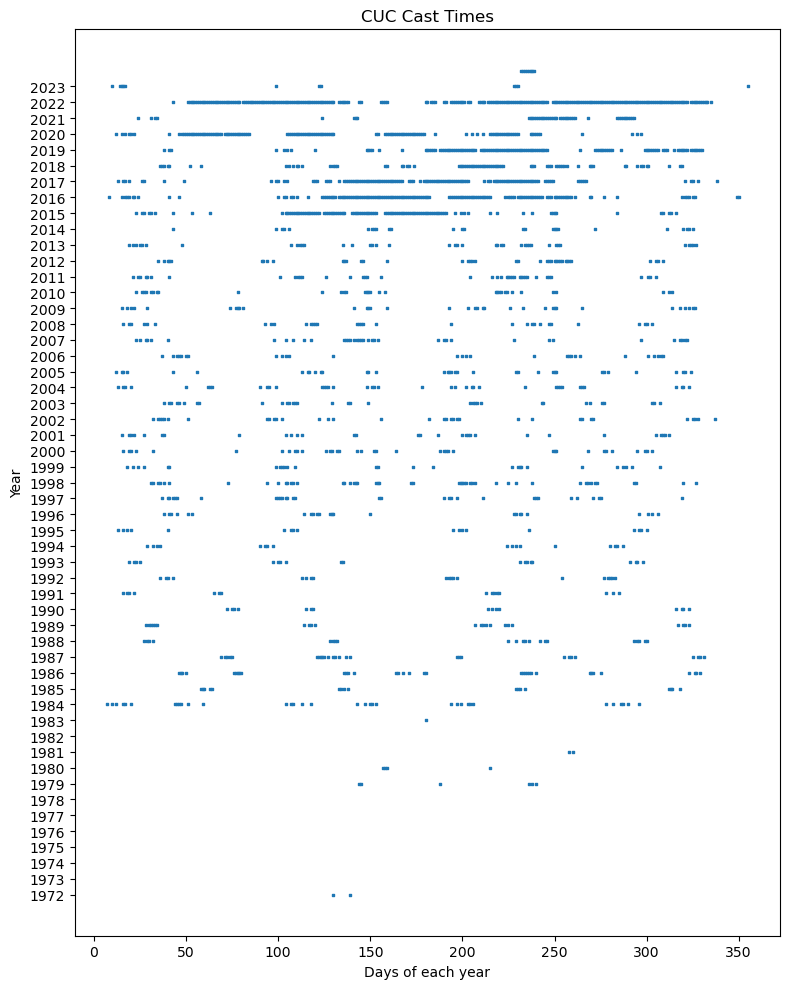

In [46]:
# Temporal resolution of California Under Current
obs_cuc = obs[obs['current'] == 'CUC']
fig, ax = plt.subplots(figsize=(8, 10))

obs_cuc_dd = obs_cuc.drop_duplicates(subset='time', keep='first')

obs_cuc_dd['time'] = pd.to_datetime(obs_cuc_dd['time'])

yearDay = obs_cuc_dd['time'].dt.dayofyear
year = obs_cuc_dd['time'].dt.year

ax.scatter(yearDay, year, s=2, marker='s' )
# ax.scatter(yearDay, year, s=2, marker='s', c=obs_cuc['month'], cmap='viridis')

ax.set_title('CUC Cast Times')
ax.set_yticks(range(1972, 2024))  
ax.set_ylabel('Year')
ax.set_xlabel('Days of each year')


plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Shelf Current Data Density')

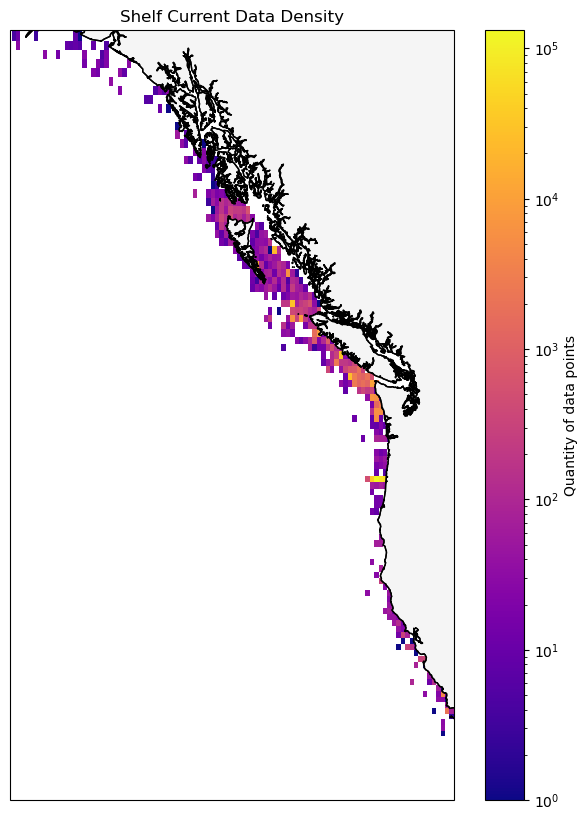

In [47]:
# Shelf Current Spatial Density
xlim, ylim = [-145.5, -120.2], [30, 60]

fig, ax = plt.subplots(1,1, figsize=(8, 10), subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})

# Make plot area
ax.set_extent(xlim + ylim)

# Draw coastline
ax.add_feature(feature.GSHHSFeature('intermediate', facecolor='whitesmoke', zorder=2))
ax.add_feature(feature.GSHHSFeature('intermediate', edgecolor='k', zorder=4))

# Prepare your data
lon = obs['longitude (degrees_east)'][obs['current'] == 'Shelf_Current']
lat = obs['latitude (degrees_north)'][obs['current'] == 'Shelf_Current']

# Create 2D histogram
hist, xedges, yedges = np.histogram2d(lon, lat, bins=100)

# Convert bin edges to meshgrid
xcenters = 0.5 * (xedges[:-1] + xedges[1:])
ycenters = 0.5 * (yedges[:-1] + yedges[1:])
X, Y = np.meshgrid(xcenters, ycenters)

# Plot using pcolormesh
pcm = ax.pcolormesh(X, Y, hist.T, cmap='plasma', norm='log', transform=crs.PlateCarree())
fig.colorbar(pcm, ax=ax, label="Quantity of data points")

ax.set_title('Shelf Current Data Density')

Text(0.5, 1.0, 'California Undercurrent Data Density')

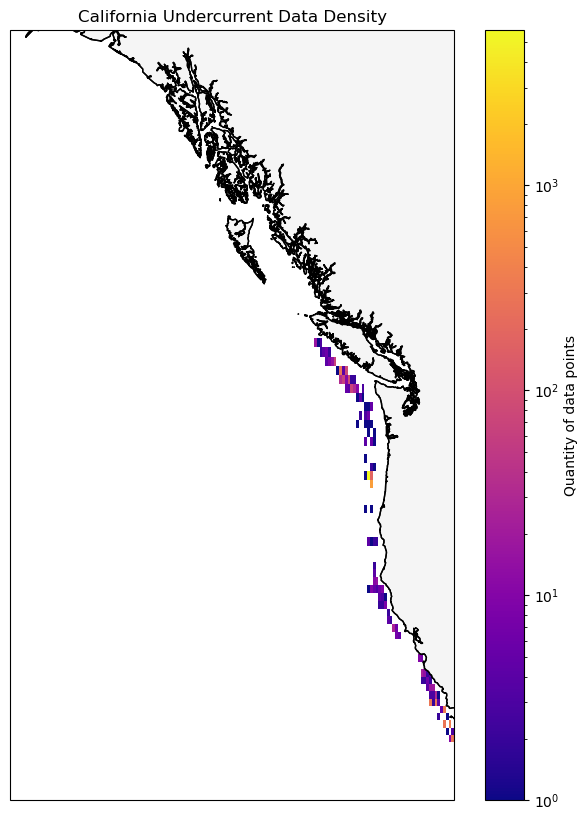

In [49]:
# CUC Spatial Density
xlim, ylim = [-145.5, -120.2], [30, 60]

fig, ax = plt.subplots(1,1, figsize=(8, 10), subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})

# Make plot area
ax.set_extent(xlim + ylim)

# Draw coastline
ax.add_feature(feature.GSHHSFeature('intermediate', facecolor='whitesmoke', zorder=2))
ax.add_feature(feature.GSHHSFeature('intermediate', edgecolor='k', zorder=4))

# Prepare data
lon = obs['longitude (degrees_east)'][obs['current'] == 'CUC']
lat = obs['latitude (degrees_north)'][obs['current'] == 'CUC']

# Create 2D histogram
hist, xedges, yedges = np.histogram2d(lon, lat, bins=50)

# Convert bin edges to meshgrid
xcenters = 0.5 * (xedges[:-1] + xedges[1:])
ycenters = 0.5 * (yedges[:-1] + yedges[1:])
X, Y = np.meshgrid(xcenters, ycenters)

# Plot using pcolormesh
pcm = ax.pcolormesh(X, Y, hist.T, cmap='plasma', norm='log', transform=crs.PlateCarree())
fig.colorbar(pcm, ax=ax, label="Quantity of data points")

ax.set_title('California Undercurrent Data Density')